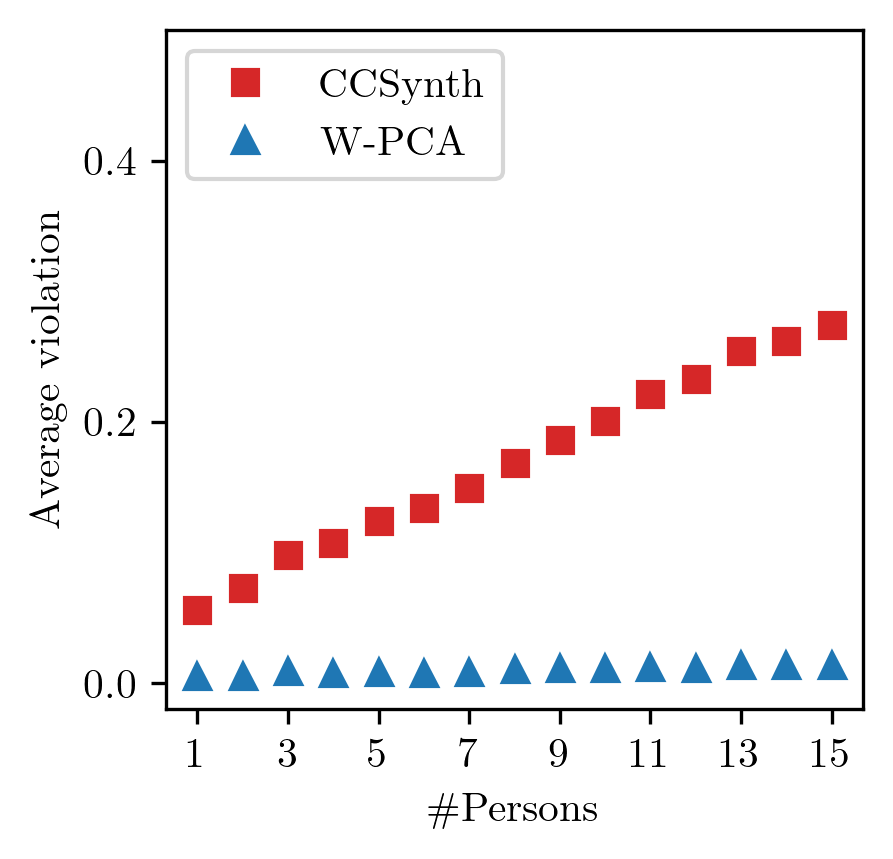

In [27]:
import prose.datainsights as di
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from sklearn.decomposition import PCA
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import os
import sys
from IPython.display import HTML
import warnings
from matplotlib import rc
from matplotlib import rcParams
import math

systemName = 'CCSynth'

np.random.seed(0)

rcParams['font.family'] = 'sans-serif'
rc('text', usetex=True)
warnings.filterwarnings('ignore')  

data_source = "data/uncompressed/har/"

sensors = ["acc", "Gyroscope"]
activities = ["lying", "running", "sitting", "standing", "walking"] 
positions = ["head", "shin", "thigh", "upperarm", "waist", "chest"] 
persons = ['person' + str(i) for i in range(1, 16)]


# Generates a df_dict of the form df_dict[person][activity][sensor], the shape of each element is 10000 X 18
def generate_df_dict():
    global df_dict
    df_dict = dict()
    
    for person in persons:      
        cur_person_data = data_source + person + "/"
        if person not in df_dict:
            df_dict[person] = dict()
        
        for activity in activities:               
            if activity not in df_dict[person]:
                df_dict[person][activity] = dict()
                
            for sensor in sensors:   
                df = None     
                for position in positions:                
                    for file in os.listdir(cur_person_data):                   
                        if not file.startswith("_"): continue
                        if activity in file and sensor in file and position in file: 
                            cur_df = pd.read_csv(cur_person_data + file, index_col=0)
                            if df is None:
                                df = cur_df
                            else:
                                df = pd.concat([df, cur_df], axis=1, ignore_index=True)
                df_dict[person][activity][sensor] = df

df_dict = None
generate_df_dict()

def get_assigned_activity():
    while True:
        activities_picked = np.random.choice(activities, len(persons))
        if len(set(activities_picked)) == len(activities): # all activities are covered
            break
    assigned_activity = dict()
    for person, activity in zip(persons, activities_picked):
        assigned_activity[person] = activity
    
    return assigned_activity

def reassign_activity(prev_assigned_activity, new_affected_person):
    new_assigned_activity = dict()
    for person in persons:
        new_assigned_activity[person] = prev_assigned_activity[person]
        
        if persons.index(person) == new_affected_person - 1:
            while new_assigned_activity[person] == prev_assigned_activity[person]:
                new_assigned_activity[person] = np.random.choice(activities, 1)[0]
    return new_assigned_activity
        
def get_df(assigned_activity, train, N=None):
    df = None
    for person in persons:
        activity = assigned_activity[person]
        for sensor in df_dict[person][activity]:
            if train:
                cur_df = df_dict[person][activity][sensor][:5000]
            else:
                cur_df = df_dict[person][activity][sensor][5000:]
                
            cur_df["sensor"] = float(sensors.index(sensor))
            cur_df["person"] = float(persons.index(person))
                
            if df is None:
                df = cur_df
            else:
                df = pd.concat([df, cur_df], axis=0, ignore_index=True)
    if N is None: 
        return df
    
    return df.sample(n=N)
                
def prepare_df(df):
    for col in df.columns:
        if len(df[col].unique()) < 20:
            df[col] =  df[col].apply(str)
    return df

all_results_pca = []
all_results_dt = []

for _ in range(10):        
    initial_activity_assignment = get_assigned_activity()
    # print("Training on", [initial_activity_assignment[person] for person in persons])
    
    train_df = get_df(assigned_activity=initial_activity_assignment, train=True, N=4000)
    
    assertions_pca = di.learn_assertions(prepare_df(train_df), max_self_violation = 1)
    assertions_dt = di.learn_assertions(prepare_df(train_df), learn_decision_tree=True, max_self_violation = 1)

    results_pca = []
    results_dt = []
    
    new_activity_assignment = initial_activity_assignment    
    
    for change in range(1, len(persons) + 1):
        new_activity_assignment = reassign_activity(new_activity_assignment, change)
        # print("--> Change", [new_activity_assignment[person] for person in persons])
        test_df = get_df(assigned_activity=new_activity_assignment, train=False, N=4000)
        
        result_pca = assertions_pca.evaluate(prepare_df(test_df)).avg_violation
        result_dt = assertions_dt.evaluate(prepare_df(test_df)).avg_violation
        
        results_pca.append(result_pca)            
        results_dt.append(result_dt)           
        
    # print('-------------------------------------')
    all_results_pca.append(results_pca)
    all_results_dt.append(results_dt)
    
rcParams['font.family'] = 'serif'
rc('text', usetex=True)
systemName = 'CCSynth'
rcParams['figure.dpi'] = 300

pca = np.mean(np.array(all_results_pca), axis=0)
dt = np.mean(np.array(all_results_dt), axis=0)

violations = np.vstack((pca, dt))

approaches = ["W-PCA", systemName]
markers = ["C0^", "C3s"]

for approach, marker in zip(approaches[::-1], markers[::-1]):
    plt.plot(np.arange(1, 16, 1), violations[approaches.index(approach)], marker, label=approach)

plt.ylim(-.02, 0.5)
plt.yticks(np.arange(0.0,0.5,0.2))
plt.xticks(np.arange(1,16,2))
plt.xlabel("\#Persons")
plt.ylabel("Average violation")
plt.legend(ncol=1, loc="upper left")    
fig = plt.gcf()
fig.set_size_inches(3, 3)
fig.savefig(os.path.join("Plots", "Figure_6_c.pdf"), bbox_inches = "tight")
plt.show()